# Challenge #1. Reservoir Evaluation


Aramco Upstream Solutions Technathon
MSU Science Park - 26-28 Oct 2018

Let's assume that we know nothing about underlying physics and learn from the data using just machine learning

In [57]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
import multiprocessing

random_state = 2018

In [58]:
train_b = pd.read_csv('aramco-data/task1/2. Training/Logs-B.csv')
train_c = pd.read_csv('aramco-data/task1/2. Training/Logs-C.csv')
train_d = pd.read_csv('aramco-data/task1/2. Training/Logs-D_Lost_Sections.csv')

test_a = pd.read_csv('aramco-data/task1/3. Testing/Logs-A.csv')
test_d = pd.read_csv('aramco-data/task1/3. Testing/Logs-D_Lost_Sections.csv')

In [59]:
train_b.head()

,Reference,Track_1,Track_2,Track_3,Track_4,Characteristic_1,Fluid_Fraction
0,176.151735,449.52114,106.79179,0.924423,18.24576,0.044960,0.03132
1,176.009779,494.77735,124.72322,1.356370,17.91681,0.062602,0.03132
2,175.854890,530.24547,126.32411,1.759663,16.71797,0.090488,0.03132
3,175.690536,545.80115,122.55946,1.916755,16.60101,0.097377,0.03132
4,175.527445,546.45174,115.30063,1.916755,16.54253,0.098116,0.03132


Let's look at feature correlations

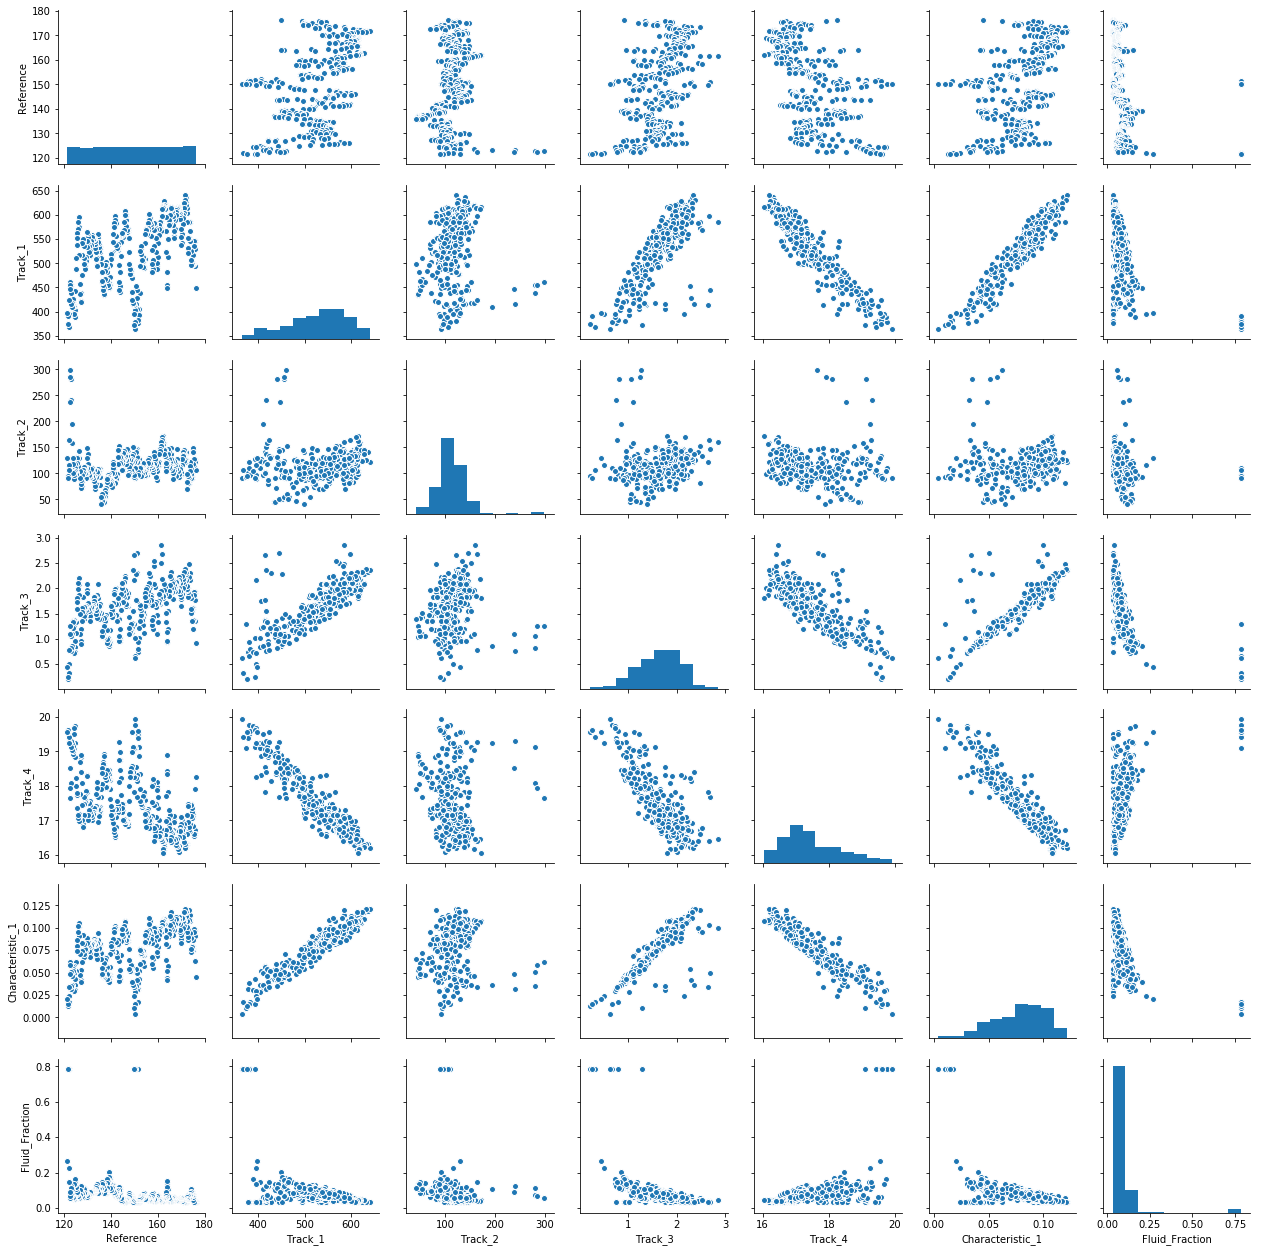

In [60]:
import seaborn as sns
sns.pairplot(train_b);

In [61]:
train_b['Fluid_Fraction'].mean()

0.08742102017971018

In [62]:
train_c.head()

,Reference,Track_1,Track_2,Track_3,Track_4,Characteristic_1,Fluid_Fraction
0,216.661514,561.846600,84.884451,1.536635,16.73990,0.093360,0.042590
1,216.502524,558.706224,88.596469,1.383191,16.74721,0.092437,0.042286
2,216.343533,553.657207,95.754421,1.547037,16.74721,0.090931,0.042204
3,216.184227,568.184370,100.570249,1.655613,16.99575,0.095192,0.039533
4,216.025237,583.821922,104.431391,1.630941,16.77645,0.099540,0.037631


In [63]:
train_c['Fluid_Fraction'].mean()

0.08436770301748256

In [64]:
train_d.head()

,Reference,Track_1,Track_2,Track_3,Track_4,Characteristic_1,Fluid_Fraction
0,316.847634,349.04519,89.279954,0.269666,19.049860,0.000038,0.783
1,316.737539,352.48089,95.623572,0.245251,18.443130,0.000038,0.783
2,316.621136,355.55840,98.238359,0.240397,17.652042,0.000038,0.783
3,316.499369,358.84790,98.267599,0.276530,17.345972,0.000472,0.783
4,316.372240,355.59495,96.231764,0.338862,17.444365,0.000038,0.783


In [65]:
train_d['Fluid_Fraction'].mean()

0.12046181560057474

In [66]:
train = train_b.append(train_c).append(train_d)

In [67]:
X_train = train.drop('Fluid_Fraction', axis=1)
y_train = train['Fluid_Fraction']

X_test_a = test_a
X_test_d = test_d

# Permutation importance

eli5 provides a way to compute feature importances for any black-box estimator by measuring how score decreases when a feature is not available; the method is also known as “permutation importance” or “Mean Decrease Accuracy (MDA)”.

In [68]:
from sklearn.model_selection import train_test_split

X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.5, random_state=random_state)

In [69]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(criterion="mae").fit(X_tr.fillna(-1), y_tr)

In [70]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(reg).fit(X_va.fillna(-1), y_va)
eli5.show_weights(perm, feature_names = X_va.columns.tolist())

Weight,Feature
0.9383 ± 0.0425,Characteristic_1
0.1565 ± 0.0071,Track_1
0.0493 ± 0.0074,Reference
0.0240 ± 0.0058,Track_4
0.0199 ± 0.0068,Track_3
0.0094 ± 0.0041,Track_2


we see that all features bring information to the model, there are no random/pure noise features

In [71]:
train['Fluid_Fraction'].mean()

0.09827387829826342

In [72]:
params = {
    'objective' : 'mae',
    'metric': 'mae',
    #'feature_fraction': .8,
    #'learning_rate': 0.001
    }
n_fold = 3
n_estimators = 50000
nthread = multiprocessing.cpu_count()
folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, nthread = nthread, n_jobs = -1)

In [73]:
%%time

prediction_a = np.zeros(X_test_a.shape[0])
prediction_d = np.zeros(X_test_d.shape[0])

for fold_n, (train_index, test_index) in enumerate(folds.split(X_train)):
    print('Fold:', fold_n)
    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(X_tr, y_tr, 
            eval_set=[(X_tr, y_tr), (X_va, y_va)], 
            verbose=250, early_stopping_rounds=100)
    
    y_pred_a = model.predict(X_test_a, num_iteration=model.best_iteration_)
    y_pred_d = model.predict(X_test_d, num_iteration=model.best_iteration_)
    prediction_a += y_pred_a
    prediction_d += y_pred_d
    
prediction_a /= n_fold
prediction_d /= n_fold

Fold: 0
Training until validation scores don't improve for 100 rounds.
[250]	training's l2: 0.00156422	valid_1's l2: 0.00255552
[500]	training's l2: 0.000965945	valid_1's l2: 0.00183363
[750]	training's l2: 0.0008902	valid_1's l2: 0.00174847
[1000]	training's l2: 0.000875846	valid_1's l2: 0.00173469
[1250]	training's l2: 0.000865499	valid_1's l2: 0.00172815
[1500]	training's l2: 0.000860064	valid_1's l2: 0.00172279
[1750]	training's l2: 0.000856403	valid_1's l2: 0.00172135
Early stopping, best iteration is:
[1738]	training's l2: 0.000856278	valid_1's l2: 0.00172008
Fold: 1
Training until validation scores don't improve for 100 rounds.
[250]	training's l2: 0.00465503	valid_1's l2: 0.00511517
[500]	training's l2: 0.00451262	valid_1's l2: 0.00507116
[750]	training's l2: 0.00446918	valid_1's l2: 0.00505939
Early stopping, best iteration is:
[702]	training's l2: 0.00447797	valid_1's l2: 0.00505763
Fold: 2
Training until validation scores don't improve for 100 rounds.
[250]	training's l2: 0.

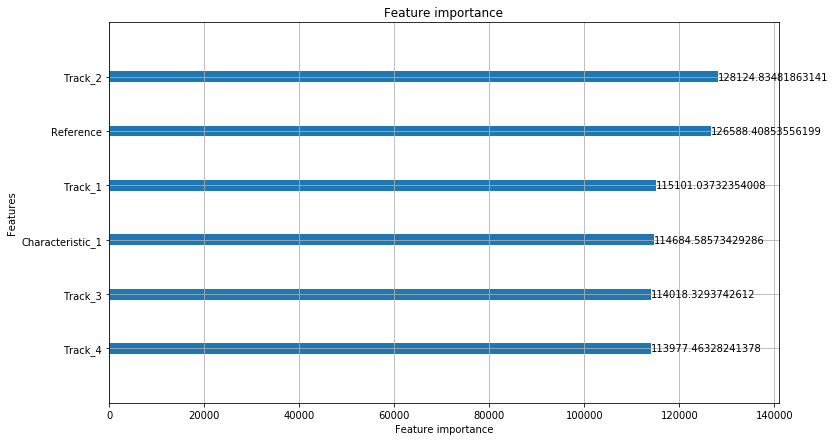

In [74]:
%matplotlib inline
lgb.plot_importance(model, importance_type='gain', figsize=(12,7));

In [75]:
test_a.head()

,Reference,Track_1,Track_2,Track_3,Track_4,Characteristic_1
0,226.575710,397.220283,58.885559,0.449736,20.657621,0.025308
1,226.563407,420.739477,62.158392,0.793581,19.482100,0.038290
2,226.541010,436.382146,77.639510,1.150514,18.644520,0.046150
3,226.489905,445.895380,86.846455,1.417029,18.059136,0.050661
4,226.419558,441.466251,92.864047,1.274250,18.644520,0.048585


In [76]:
test_a['Fluid_Fraction'] = prediction_a
test_d['Fluid_Fraction'] = prediction_d

In [77]:
test_a.head()

,Reference,Track_1,Track_2,Track_3,Track_4,Characteristic_1,Fluid_Fraction
0,226.575710,397.220283,58.885559,0.449736,20.657621,0.025308,0.149652
1,226.563407,420.739477,62.158392,0.793581,19.482100,0.038290,0.094111
2,226.541010,436.382146,77.639510,1.150514,18.644520,0.046150,0.074702
3,226.489905,445.895380,86.846455,1.417029,18.059136,0.050661,0.072238
4,226.419558,441.466251,92.864047,1.274250,18.644520,0.048585,0.070949


In [78]:
test_d.head()

,Reference,Track_1,Track_2,Track_3,Track_4,Characteristic_1,Fluid_Fraction
0,308.571924,612.39525,94.665231,1.811031,15.64340,0.106913,0.031647
1,308.419243,608.00194,93.844318,1.893699,15.73843,0.105824,0.031710
2,308.266562,606.68614,93.175453,1.948597,15.80422,0.105495,0.031581
3,308.104101,606.60573,92.503664,1.946580,15.82615,0.105476,0.031587
4,307.938170,607.56334,91.593569,1.914906,15.76036,0.105715,0.031404


In [79]:
!mkdir aramco-data/output

mkdir: cannot create directory ‘aramco-data/output’: File exists


Save calculated data to the files

In [80]:
test_a.to_csv('aramco-data/output/Logs-A--solved.csv', index=False)
test_d.to_csv('aramco-data/output/Logs-D_Lost_Sections--solved.csv', index=False)

# Comparison of real Fluid_Fraction with one calculated from the model
strictly speaking, that is not correct in terms of ML, because we have model trained on this data, just for the illustraion

In [81]:
train.head()

,Reference,Track_1,Track_2,Track_3,Track_4,Characteristic_1,Fluid_Fraction
0,176.151735,449.52114,106.79179,0.924423,18.24576,0.044960,0.03132
1,176.009779,494.77735,124.72322,1.356370,17.91681,0.062602,0.03132
2,175.854890,530.24547,126.32411,1.759663,16.71797,0.090488,0.03132
3,175.690536,545.80115,122.55946,1.916755,16.60101,0.097377,0.03132
4,175.527445,546.45174,115.30063,1.916755,16.54253,0.098116,0.03132


In [82]:
train_b['Predicted_Fluid_Fraction'] = model.predict(train_b.copy().drop('Fluid_Fraction', axis=1), num_iteration=model.best_iteration_)

In [83]:
train_b.head()

,Reference,Track_1,Track_2,Track_3,Track_4,Characteristic_1,Fluid_Fraction,Predicted_Fluid_Fraction
0,176.151735,449.52114,106.79179,0.924423,18.24576,0.044960,0.03132,0.138450
1,176.009779,494.77735,124.72322,1.356370,17.91681,0.062602,0.03132,0.073302
2,175.854890,530.24547,126.32411,1.759663,16.71797,0.090488,0.03132,0.030827
3,175.690536,545.80115,122.55946,1.916755,16.60101,0.097377,0.03132,0.035043
4,175.527445,546.45174,115.30063,1.916755,16.54253,0.098116,0.03132,0.033542


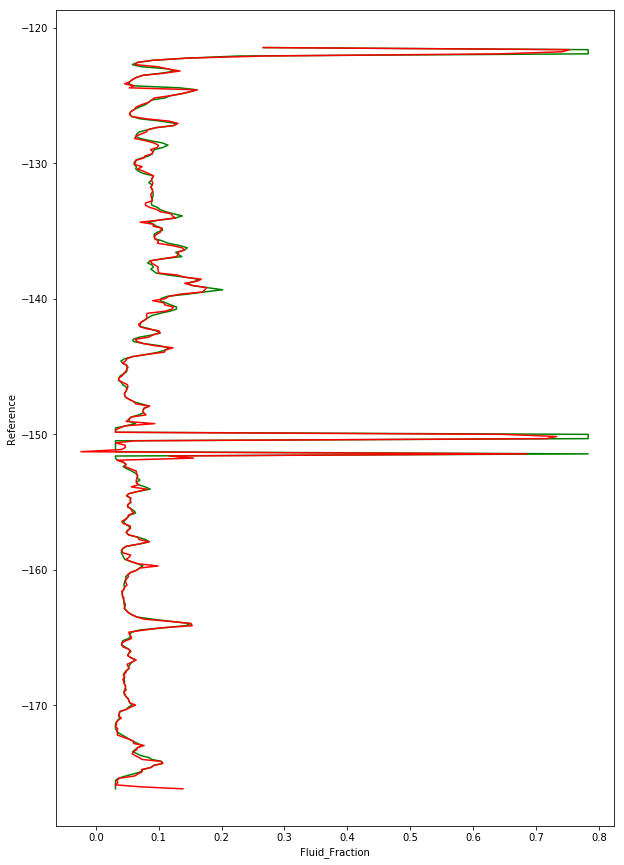

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,15))

plt.plot(train_b['Fluid_Fraction'], -train_b['Reference'], 'g')
plt.plot(train_b['Predicted_Fluid_Fraction'], -train_b['Reference'], 'r')

plt.xlabel('Fluid_Fraction')
plt.ylabel('Reference');